# *Thermal Transport in a Ti:Sapphire Crystal*

In this demo, we solve the three-dimensional diffusion equation in a cylindrical Ti:sapphire crystal,
with Dirichlet boundary condition $u_D$ on the sides and a constant source term heating a portion of
the crystal.

$$
\begin{align}
  \frac{\partial T}{\partial t}   &= \alpha\nabla^2 T + g    \quad\text{in a cylinder} \\
  T    &= T_D  \hphantom{Du+g}\quad\text{on the side boundary} \\
  T    &= T_0  \hphantom{Du+g}\quad\;\text{at $t = 0$}
\end{align}
$$
with boundary conditions
$$
  T_D = T_0,
$$
and source term
$$
  g = \delta_T \exp\bigl[ -\tfrac{1}{2}\bigl(\tfrac{x^2 + y^2}{\xi^2}\bigr)^p \bigr]
            [\exp(-z/\lambda) + \exp((z-l)/\lambda)], \\
$$

The coefficient $\delta_T$ we determine by noting that the average power absorbed by the crystal
must equal
$$
  P_\text{avg} = \int_\text{crystal} \rho c_p g(\vec{r}) \ud^3\vec{r},
$$
where $\rho$ and $c_p$ respectively denote the crystal's mass density and specific heat.
If we treat the transverse beam dimension $\sigma$ as much smaller than the crystal radius,
so that we can approximate the transverse integrals as going out to infinity, 

## Typical Properties of sapphire wafers

[data source](http://valleydesign.com/sappprop.htm)


### Mechanical Properties
| property                     | value                        |
| :--------------------------- | :--------------------------- |
| Density                      | 3.98 g/cm$^3$                |
| Young's Modulus (elasticity) | 345 GPa / $50\times10^6$ psi |
| Bulk Modulus (compression)   | 250 GPa / $36\times10^6$ psi |
| Shear Modulus (rigidity)     | 145 GPa / $21\times10^6$ psi |
| Poisson's Ratio              | 0.29                         |
| Melting Point                | 2040°C / 3700°F / 2310 K     |
 
### Thermal Properties
| property                   | value                 |
| :------------------------- | :-------------------- |
| Thermal Conductivity       |                       |
| $\quad$ Perpendicular to C | at 23°C: 23.0  W/m°C  |
|                            | at 77°C: 16.8  W/m°C  |
| $\quad$ Parallel to C      | at 24°C: 25.8  W/m°C  |
|                            | at 70°C: 17.35 W/m°C  |
| Specific Heat              | at 18°C: 756 J/kg°C   |
|                            | at -182°C: 104 J/kg°C |

### Electrical Properties
| property                   | value                    |
| :------------------------- | :----------------------- |
| Volume Resistivity         | at 25°C $10^{14}$ ohm/cm |
| Dielectric Strength        | $4.8 \times 10^5$        |
| Dielectric Constant:       |                          |
| $\quad$ Perpendicular to C | 9.4                      |
| $\quad$ Parallel to C      | 11.5                     |
| Dissipation Factor         | $10^-4\tan\delta$        |


### CTE (Coefficient of Thermal Expansion), $\ \times 10^6 /\,{}^\circ\text{C}$
| Temp °C | Perpendicular to C | Parallel to C |
| ------: | -----------------: | ------------: |
|      70 |               6.95 |          5.90 |
|     100 |               7.08 |          6.05 |
|     200 |               7.66 |          6.60 |
|     300 |               8.30 |          7.32 |
|     400 |               9.00 |          8.07 |
|     500 |               9.63 |          8.88 |
|     600 |              10.45 |          9.77 |

### Optical properties

[(from RP-Photonics)](https://www.rp-photonics.com/titanium_sapphire_lasers.html)<br>
Index of refraction, $800.0\,\mathrm{nm}$ ($1.5498\,\mathrm{eV}$): $1.7601$<br>
Temperture dependence of the index of refraction: $13\times10^{-6}\,\mathrm{K}^{-1}$<br>
Emission cross-section at $790\,\mathrm{nm}$ (pol. $\|$ $c$-axis): $4.1\times10^{-19}$

For graphs of the refractive index, see, for example,
[0.2–5 µm](https://refractiveindex.info/?shelf=3d&book=crystals&page=sapphirehttps://refractiveindex.info/?shelf=3d&book=crystals&page=sapphire),
but note the data there is for _sapphire_, not Ti:sapphire.

### Coefficient of thermal diffusion

Make sure we have the dimensions right! They ought to be area/time.
And make sure we have the units right! They ought to be $\mathrm{cm}^2/\mathrm{s}$.
$$
  \alpha = \frac{\kappa}{\rho c_p} \approx
           \frac{24~\text{W}\,/\,(\text{m} ˚\text{C})}{
                 3.98\times10^3~\text{kg}\,/\,\text{m}^3 \cdot 756~\text{J}\,/\,(\text{kg} ˚\text{C})}
         \approx 7.98\times10^{-6}~\text{m}^2\,/\,\text{s}
         \approx 7.98\times10^{-2}~\text{cm}^2\,/\,\text{s}
$$

## Preamble

Needed imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.graph_objects
import numpy as np
import time as tm
import copy
# import math as m

from fenics import *
from mshr import *   # now deprecated (?), transition to alternate mesh generator (?)

Define function to grab both min and max of a list:

In [2]:
def minmax(it):
    min = max = None
    for val in it:
        if min is None or val < min:
            min = val
        if max is None or val > max:
            max = val
    return min, max

Define averaging routines for circle and cylindrical shell:

In [3]:
# trapezoidal weights
def trap_weights(n):
    wts = np.ones(n)
    wts[0] = 0.5
    wts[-1] = 0.5
    return(wts)

# compute average of u on a circle of radius r at longitudinal position z
# using a given number of points (num_thetas) spaced evenly about the circle
# NB: do NOT bother doing something fancy here --- b/c u is periodic on the
# circle, a Riemann sum converges exponentially fast as num_thetas increases
def temp_on_circle(u, r, z, num_thetas):
    thetas = np.linspace(0., 2.*pi, num_thetas, endpoint = False) 
    circle_points = [(r * cos(th_), r * sin(th_), z) for th_ in thetas]
    return(np.mean([u(pt) for pt in circle_points]))

# compute average of u over the surface of a cylinder of radius r
# between longitudinal positions z0 znd z1
def temp_on_cylinder(u, r, z0, z1, num_zs, num_thetas):
    zs = np.linspace(z0, z1, num_zs)
    t_circ = [temp_on_circle(u, r, z_, num_thetas) for z_ in zs]
    return(np.average(t_circ, weights = trap_weights(num_zs)))

Temperature dependence of Ti:Sapphire index of refraction.

In [4]:
# index of refraction for Ti:Saphire
refractive_index_at_20C = 1.7542 # Ti:Al2O3 at wavelength 800 nm, T = 20 C
dndT = 13e-6  # 1/K

def refractive_index_n(T):
    "refractive index as a function of temperature given in degrees C"
    return refractive_index_at_20C + dndT * (T - 20)

simulation parameters:

In [5]:
## set up the problem and define (some of) the main parameters

# simulation parameters
# -- crystal properties
rho_Al2O3 = 3.98   # density Al2O3 / (gm / cm^-3)
cp_Al2O3  = 0.756  # specific heat Al2O3 (J / (gm . K))
a_Al2O3 = 7.98e-2  # cm^2/s diffusion constant of sapphire (Al2O3)
a_perp  = 7.64e-2  # perpendicular to C
a_para  = 8.57e-2  # parallel to C
# -- crystal dimensions
diam =  1.0        # diameter /cm
leng =  3.0        # length /cm
# -- time step
T = 2.0            # total simulation time / sec
n_steps = 200      # number of time steps
dt = T / n_steps   # size of time step
nip = 10           # number of intervals between records
# --  mesh density
md = 40            # mesh density within cylinder

# derived parameters
rad = diam / 2  # radius
lh  = leng / 2  # half-length
rad2 = rad * rad

# # scaling
# # (not used for now, but retaining as a reminder)
# # -- omega & k (wave-number)
# omega = 1.                       # rad / s
# wvnum = np.sqrt(omega / a_Al2O3)  # 1 / cm
# # -- scaled dimensions
# rad_scl  = wvnum * diam / 2      # scaled radius
# lh_scl   = wvnum * leng / 2      # scaled half-length
# # -- scaled time
# T_scl  = omega * T   # scaled simulation time
# dt_scl = omega * dt  # scaled time-step

print("duration:  %5.3f" % T)
print("time-step: %5.3f" % dt)
print("plot-step: %5.3f" % (dt * nip))
print("num-plots: %5d" % (n_steps / nip))

duration:  2.000
time-step: 0.010
plot-step: 0.100
num-plots:    20


In [6]:
# create mesh: Cylinder(p_top, p_bot, r_top, r_bot)
# ### not yet ### # -- do this in scaled coördinates
# domain = Cylinder(Point(0, 0, lh_scl), Point(0., 0., -lh_scl), rad_scl, rad_scl)
domain = Cylinder(Point(0, 0, lh), Point(0., 0., -lh), rad, rad)
mesh = generate_mesh(domain, md)
# and define function space
V = FunctionSpace(mesh, 'P', 1)

Generating mesh with CGAL 3D mesh generator


In [7]:
mesh

In [8]:
# define boundary and initial conditions, and sources
T0    = 20.0   # boundary temperature / deg C
wdT   =  0.15  # beam sigma / cm
ldT   =  0.40  # absorption length / cm
Pabs  =  8.00  # average absorbed laser power / W
Tdot  = Pabs / (rho_Al2O3 * cp_Al2O3 * 4 * np.pi * wdT ** 2 * ldT * (1 - np.exp(- leng / ldT)))
sg_px = 1      # 1
sg_py = 1      # 1
print('T_dot = {0:6.2f}'.format(Tdot))

# define Dirichlet boundary condition for sides
tol = 1.e-13
def boundary_D(x, on_boundary):
    return on_boundary and near(x[0]*x[0] + x[1]*x[1], rad2, tol)
bc = DirichletBC(V, Constant(T0), boundary_D)

# exp(decay) x SG
hse = Expression('Tdot * (exp(-(x[2]+l/2)/dl) + exp((x[2]-l/2)/dl)) \
                    * exp(-0.5 * pow((x[0]*x[0] + x[1]*x[1])/(w*w), px))',
                 degree=1, Tdot=Tdot, w=wdT, l=leng, dl=0.3*leng, px=sg_px)

# define initial value
# u_n = interpolate(hse, V)
u_n = interpolate(Constant(T0), V)

T_dot =  23.52


define the variational problem and main simulation function `evolve`:

In [9]:
# define variational problem
u = TrialFunction(V)
v = TestFunction(V)

# source term
# f = Constant(0)  # no source term
f = hse           # source term

# F = u*v*dx + dt*a_Al2O3*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx + gi*v*ds  # w/ Neumann BC
F = u*v*dx + dt*a_Al2O3*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx  # w/ Dirichlet + initial condition
a, L = lhs(F), rhs(F)

# define time-evolution function
def evolve():

    # report initial state
    yield u_n

    # time-stepping
    u = Function(V)
    t = 0
    for n in range(1, n_steps + 1):

        # update current time
        t += dt

        # compute solution
        solve(a == L, u, bc)

        # report current state
        if n % nip == 0:
            yield u

        # update previous solution
        u_n.assign(u)

In [10]:
# for 3D plots, get the facets, and build an array
# containing the indices of their coordinates
inds = []
for item in dolfin.cpp.mesh.facets(mesh):
    inds.append(item.entities(0).tolist())

# we will provide these indices to plotly so it can draw proper surfaces
inds = np.array(inds)
ii = inds[:, 0]
jj = inds[:, 1]
kk = inds[:, 2]

# get node coördinate values and ranges
xvals = mesh.coordinates()[:,0]
yvals = mesh.coordinates()[:,1]
zvals = mesh.coordinates()[:,2]
xmin, xmax = xvals.min(), xvals.max()
ymin, ymax = yvals.min(), yvals.max()
zmin, zmax = zvals.min(), zvals.max()

**NB**: Before executing the next two cells a second time,
you must first reëxecute the previous three code cells.

simulation time: 32.050 seconds


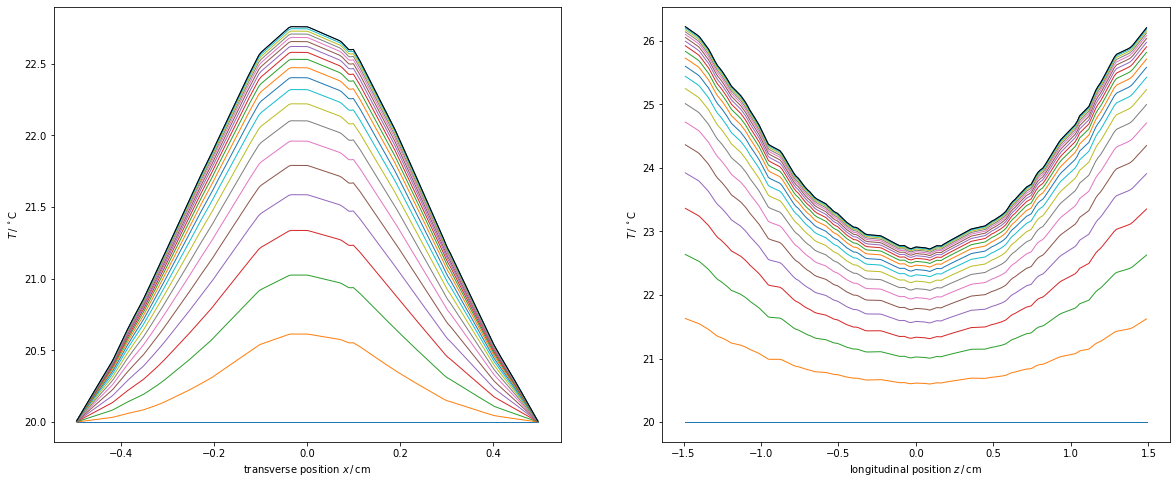

In [11]:
n_rows = 1
n_cols = 2
# fig_wd = 15
# default sizing here yields unit aspect ratio
# plt.figure(figsize = (fig_wd, fig_wd * n_rows // n_cols))
# plt.subplot(n_rows, n_cols, idx)

fig = plt.figure(figsize=(20,8))
fig1 = fig.add_subplot(n_rows, n_cols, 1)
fig2 = fig.add_subplot(n_rows, n_cols, 2)

tol = 8.e-3  # avoid points outside domain (for a coarse mesh, increase this value)
xv = np.linspace(xmin * (1 - tol), xmax * (1 - tol), 201)
zv = np.linspace(zmin * (1 - tol), zmax * (1 - tol), 201)
radpts = [(x_, 0, 0) for x_ in xv]
axipts = [(0, 0, z_) for z_ in zv]

set_log_level(40)

idx = 0
t0 = tm.time()
for u in evolve():
    idx += 1
    ux = np.array([u(pt) for pt in radpts])
    uz = np.array([u(pt) for pt in axipts])
    fig1.plot(xv, ux, lw=1)
    fig2.plot(zv, uz, lw=1)  
t1 = tm.time()

fig1.plot(xv, ux, 'k', lw=1)
fig2.plot(zv, uz, 'k', lw=1)  

fig1.set_xlabel(r'transverse position $x\,/\,\mathrm{cm}$')
fig1.set_ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')
fig2.set_xlabel(r'longitudinal position $z\,/\,\mathrm{cm}$')
fig2.set_ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')

fig.savefig('heat_decay_profiles.pdf')
fig.show()

print("simulation time: %4.3f seconds" % (t1 - t0))

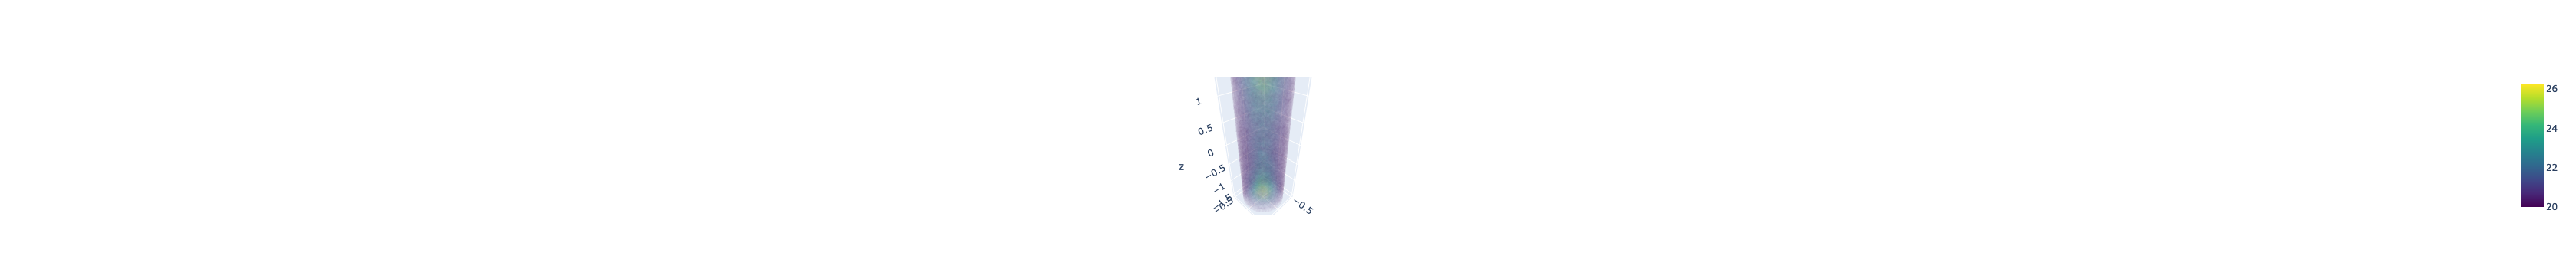

In [12]:
uvals = u.compute_vertex_values()

fig = plotly.graph_objects.Figure(
    data=[plotly.graph_objects.Mesh3d(
        x=xvals, y=yvals, z=zvals,
        i=ii, j=jj, k=kk,
        colorscale='viridis',
        intensity=uvals,
        alphahull=-1,
        opacity=0.020
    )]
)
fig.update_layout(scene_aspectmode='data')
fig.show()

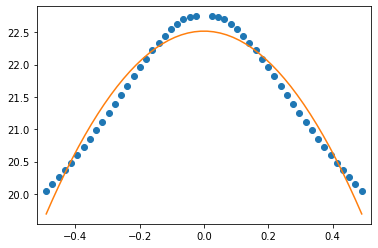

In [13]:
rs = np.linspace(rad / 20, rad * (1 -  2e-2), 25)
ts = [ temp_on_cylinder(u_n, r_, -0.1, +0.1, 11, 20) for r_ in rs ]
rs = np.concatenate((-np.flip(rs), rs))
ts = np.concatenate((np.flip(ts), ts))

# calculate polynomial
z = np.polyfit(rs, ts, 2)
f = np.poly1d(z)

# calculate new x's and y's
rs_new = np.linspace(rs[0], rs[-1], 50)
ts_new = f(rs_new)

plt.plot(rs, ts, 'o', rs_new, ts_new)
plt.xlim([-0.52, 0.52])
plt.show()

In [14]:
f

poly1d([-11.76103168,   0.        ,  22.51612262])

In [15]:
n_drop = 10
# calculate polynomial
z = np.polyfit(rs[n_drop:-n_drop], ts[n_drop:-n_drop], 2)
f = np.poly1d(z)

# calculate new x's and y's
rs_new = np.linspace(rs[n_drop], rs[-(n_drop+1)], 50)
ts_new = f(rs_new)

plt.plot(rs, ts, 'o', rs_new, ts_new)
plt.xlim([-0.52, 0.52])
plt.show()

In [16]:
f

poly1d([-1.77664452e+01,  2.86484937e-14,  2.27208288e+01])

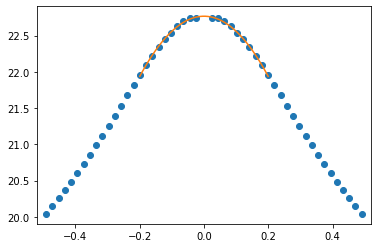

In [17]:
n_drop = 15
# calculate polynomial
z = np.polyfit(rs[n_drop:-n_drop], ts[n_drop:-n_drop], 2)
f = np.poly1d(z)

# calculate new x's and y's
rs_new = np.linspace(rs[n_drop], rs[-(n_drop+1)], 50)
ts_new = f(rs_new)

plt.plot(rs, ts, 'o', rs_new, ts_new)
plt.xlim([-0.52, 0.52])
plt.show()

In [18]:
f

poly1d([-20.8460909 ,   0.        ,  22.76656621])

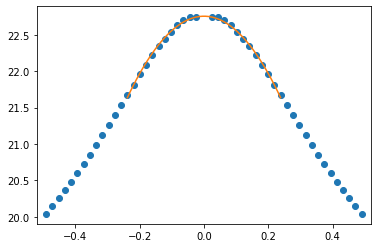

In [19]:
n_drop = 13
# calculate polynomial
z = np.polyfit(rs[n_drop:-n_drop], ts[n_drop:-n_drop], 2)
f = np.poly1d(z)

# calculate new x's and y's
rs_new = np.linspace(rs[n_drop], rs[-(n_drop+1)], 50)
ts_new = f(rs_new)

plt.plot(rs, ts, 'o', rs_new, ts_new)
plt.xlim([-0.52, 0.52])
plt.show()

In [20]:
f

poly1d([-19.72294909,   0.        ,  22.75355492])